# Emulate FATES

This script trains ML models to predict coexistence (TRUE/FALSE), ShannonE, and the number of `FailedPFTs`. The coexistence model was pretty good with a custom threshold for TRUE (> 0.15). The FailedPFTs model can distinguish between simulations that will have 3 and 4 failing pfts from 1 and 2.

I think it is worth using the coex and FailedPFTs models together to predict successful parameterizations. This should increase our efficiency of successful parameterizations from 6% to 22% (at 100 years, not equililbrium).

In [16]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', 500)
import joblib
from sklearn.ensemble import RandomForestClassifier

## Functions

In [17]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
from sklearn.metrics import confusion_matrix
import pandas as pd

def labeled_confusion_matrix(y_true, y_pred, labels=[0, 1], label_names=None):
    """
    Returns a labeled confusion matrix using pandas DataFrame.
    
    Args:
    - y_true: list or array-like, Ground truth target values.
    - y_pred: list or array-like, Estimated target values.
    - labels: list, The set of labels to include in the confusion matrix.
    - label_names: list or None, Names of the labels for better visualization.
    
    Returns:
    - DataFrame of the confusion matrix.
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Check if custom label names are provided
    if label_names:
        labels = label_names

    # Convert the matrix to a DataFrame for better labeling
    df_cm = pd.DataFrame(
        cm,
        columns=[f'Predicted {label}' for label in labels],
        index=[f'Actual {label}' for label in labels]
    )
    return df_cm


## Import data

In [18]:
raw_df = pd.read_csv('all_member_output_101223.csv')
raw_df.info()
print("\n")

# Drop first column
raw_df.drop(columns=raw_df.columns[0], axis=1, inplace=True)
print(list(raw_df.columns))

df = raw_df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Columns: 117 entries, Unnamed: 0 to case_tag
dtypes: float64(113), int64(4)
memory usage: 2.7 MB


['BA', 'AGB', 'TreeStemD', 'ResproutD_oak', 'ResproutD_shrub', 'ShannonE', 'NPP', 'FailedPFTs', 'Pct_shrub_cover_canopy', 'Pct_shrub_cover', 'Combustible_fuel', 'BA_pine', 'BA_cedar', 'BA_fir', 'BA_shrub', 'BA_oak', 'inst', 'fates_recruit_seed_alloc_mature_1', 'fates_recruit_seed_alloc_mature_2', 'fates_recruit_seed_alloc_mature_3', 'fates_recruit_seed_alloc_mature_4', 'fates_recruit_seed_alloc_mature_5', 'fates_recruit_seed_dbh_repro_threshold_1', 'fates_recruit_seed_dbh_repro_threshold_2', 'fates_recruit_seed_dbh_repro_threshold_3', 'fates_recruit_seed_dbh_repro_threshold_5', 'fates_fire_alpha_SH_1', 'fates_fire_alpha_SH_2', 'fates_fire_alpha_SH_3', 'fates_fire_alpha_SH_4', 'fates_fire_alpha_SH_5', 'fates_fire_bark_scaler_1', 'fates_fire_bark_scaler_2', 'fates_fire_bark_scaler_3', 'fates_fire_bark_scaler_4', 'fate

## Clean

In [19]:
df.fillna(0, inplace=True)

## Add coexistence variable

We define coexistence as runs where there were no failed pfts.

A failed pft is defined as one that had basal area [m2 ha-1] < 0.1

The goal of the emulator is to increase the success rate of coexistence.

In [20]:
df['coexistence'] = df['FailedPFTs'] == 0
coex_table = df['coexistence'].value_counts()

print("\n")

print('Coexistence success rate:',coex_table[1]/coex_table[0] * 100, "%")



Coexistence success rate: 6.403940886699508 %


## Split data into train and test sets

While ensuring that the train and test sets have equal ratios of coexistence to non-coexistence

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.1, random_state = 42)

# Split the data into training and test sets, maintaining an equal proportion of veg and non-veg labels in each.
for train_index, test_index in split.split(df, df['coexistence']):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]
    
X_cols = train_set.columns[train_set.columns.str.contains('fates')]
train_X = train_set[X_cols]
test_X = test_set[X_cols]

#Create vars to be predicted
train_y_coex = train_set["coexistence"].copy()
train_y_shannonE = train_set["ShannonE"].copy()
train_y_failedPFTs = train_set["FailedPFTs"].copy()

test_Y_coex = test_set["coexistence"].copy()
test_y_shannonE = test_set["ShannonE"].copy()
test_y_failedPFTs = test_set["FailedPFTs"].copy()

### Check dataset evenness
`StratifiedShuffleSplit` ensures that the train and test sets have similar ratios of coexistence to competitive exclusion, but we have an uneven number of cases where coexistence occurred vs. did not. To address this we oversample the coexistence cases (see below).

In [22]:
print("train:",train_y_coex.value_counts())
print("test:",test_set['coexistence'].value_counts())

train: coexistence
False    2557
True      164
Name: count, dtype: int64
test: coexistence
False    285
True      18
Name: count, dtype: int64


## Set up a data transformation pipeline to prepare the data for machine learning


Here we standardize the data, but some algorithms (some neural networks), need normalized data 0-1.
Normalizing can make outliers have a big effect on the data though ("squishing down"), so removing outliers can be helpful before normalizing.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# This is for if I need to define a custom data transformation function
from sklearn.base import BaseEstimator, TransformerMixin

# Data transformation pipeline
transformation_pipeline = Pipeline([
        ('std_scaler', StandardScaler()), # Scale the data by substracting mean and dividing by sigma
    ])

# Apply transformation pipeline to training data
X = transformation_pipeline.fit_transform(train_X)

# Apply to test data

X_test = transformation_pipeline.fit_transform(test_X)

## Create another training set using oversampling to balance out the examples of coexistence


The balanced training datasets are called `X_resampled` and `y_resampled`

In [24]:
import numpy as np
from sklearn.datasets import make_classification
from collections import Counter

train_y_coex_array = np.array(train_y_coex)

print("Original dataset shape:", Counter(train_y_coex_array))

# Identify the indices of the minority class
minority_class_indices = np.where(train_y_coex_array == True)[0]

# Calculate how many samples to duplicate to balance the classes
desired_samples = len(train_y_coex_array) - 2 * len(minority_class_indices)
print(desired_samples)

duplicate_samples = desired_samples - len(minority_class_indices)

# Randomly select instances from the minority class to be duplicated
duplicating_indices = np.random.choice(minority_class_indices, size=duplicate_samples)

# Duplicate the selected instances
X_duplicated = X[duplicating_indices]
y_duplicated = train_y_coex_array[duplicating_indices]

# Concatenate the original and duplicated data
X_resampled = np.vstack((X, X_duplicated))
y_resampled = np.hstack((train_y_coex, y_duplicated))

print("Resampled dataset shape:", Counter(y_resampled))

Original dataset shape: Counter({False: 2557, True: 164})
2393
Resampled dataset shape: Counter({False: 2557, True: 2393})


## Define a naive classifier to compare our classifiers to

This classifier always predicts no coexistence.

In [25]:
from sklearn.base import BaseEstimator
class NeverCoexist(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        
        #always predicts false (0)
        return np.zeros((len(X), 1), dtype=bool)

In [26]:
# Naive classifier
never_coexist = NeverCoexist()
# test naive classifier
naive_scores = cross_val_score(never_coexist, X, train_y_coex, cv= 10, scoring="accuracy")
print("Naive:",display_scores(naive_scores))

Scores: [0.91941392 0.97058824 0.94485294 0.92279412 0.91544118 0.94485294
 0.95220588 0.94852941 0.91911765 0.95955882]
Mean: 0.9397355095884506
Standard deviation: 0.018290331458515947
Naive: None


# Emulate coexistence

## Evaluate Decision Tree

Decision tree performs worse that the naive classifier.

In [27]:
from sklearn.tree import DecisionTreeClassifier

# decision tree classifier
tree = DecisionTreeClassifier()

# test regression tree
tree_scores = cross_val_score(tree, X, train_y_coex, cv= 10, scoring="accuracy")
print("Decision Tree:",tree_scores)

Decision Tree: [0.87912088 0.90808824 0.88970588 0.88602941 0.88970588 0.88235294
 0.88970588 0.88970588 0.88602941 0.87132353]


## Evaluate Random Forest to predict coexistence on unbalanced data

## Look at feature importances

### Fit basic model and look at feature importances

In [28]:
# These hyperparameters were determined to be the best from a grid search algorithm below
# However, these hyperparameters didn't change the performance of the model very much
forest = RandomForestClassifier(n_estimators=100,max_features=0.25)

forest.fit(X,train_y_coex)
feature_importances = forest.feature_importances_
fi = pd.DataFrame(np.column_stack([X_cols,feature_importances]),columns=["param","feature_importance"])
fi.sort_values("feature_importance",ascending=False)

,param,feature_importance
35,fates_leaf_slatop_4,0.034796
25,fates_fire_nignitions_0,0.02272
36,fates_leaf_slatop_5,0.020742
73,fates_nonhydro_smpsc_3,0.019122
97,fates_allom_agb1_5,0.019096
42,fates_leaf_vcmax25top_5,0.016969
43,fates_mort_scalar_cstarvation_1,0.016909
16,fates_fire_bark_scaler_3,0.016893
53,fates_frag_seed_decay_rate_4,0.016579
3,fates_recruit_seed_alloc_mature_4,0.016534


## Use cross-validation to evaluate model

In [29]:


forest_scores = cross_val_score(forest,X,train_y_coex,cv=10,scoring="accuracy")

In [30]:
print("Naive:")
print(display_scores(naive_scores))
print("\n")
print("Forest")
print(display_scores(forest_scores))

Naive:
Scores: [0.91941392 0.97058824 0.94485294 0.92279412 0.91544118 0.94485294
 0.95220588 0.94852941 0.91911765 0.95955882]
Mean: 0.9397355095884506
Standard deviation: 0.018290331458515947
None


Forest
Scores: [0.93772894 0.94117647 0.94117647 0.94117647 0.94117647 0.94117647
 0.94117647 0.9375     0.9375     0.9375    ]
Mean: 0.9397287761258349
Standard deviation: 0.001774164541686241
None


### Confusion matrices

The RF model `forest` never predicts coexistence when trained on unbalanced data, but the one trained on balanced data, `forest_resampled`, does.

In [31]:
forest = RandomForestClassifier(n_estimators=100,max_features=0.25, class_weight="balanced", random_state=42)
forest_preds = cross_val_predict(forest,X,train_y_coex,cv=3)

print("Forest")
print(confusion_matrix(train_y_coex,forest_preds))
print("\n")

print("Naive")
naive_preds = cross_val_predict(never_coexist, X, train_y_coex, cv= 3)
print(confusion_matrix(train_y_coex,naive_preds))

Forest
[[2557    0]
 [ 164    0]]


Naive
[[2557    0]
 [ 164    0]]


In [32]:
forest_resampled = RandomForestClassifier(n_estimators=100,max_features=0.25, class_weight="balanced")
forest_preds_resampled = cross_val_predict(forest_resampled,X_resampled,y_resampled,cv=3)

print("Forest resampled")
labeled_confusion_matrix(y_resampled, forest_preds_resampled, labels=[0, 1], label_names=["Exclusion","Coexistence"])

Forest resampled


,Predicted Exclusion,Predicted Coexistence
Actual Exclusion,2550,7
Actual Coexistence,0,2393


## Evalute random forest on balanced data

It performs much better on the balanced training data

In [33]:
forest_scores_resampled = cross_val_score(forest_resampled,X_resampled,y_resampled,cv=10,scoring="accuracy")
display_scores(forest_scores_resampled)

Scores: [0.9959596 1.        1.        1.        1.        1.        0.9979798
 0.9979798 1.        1.       ]
Mean: 0.9991919191919191
Standard deviation: 0.0013400504203456248


### ... but still never predicts coexistence on the test data

Therefore, the expected overfitting from the oversampling did become an issue.

Next, we will try tinkering with the threshold value at which point the random forest predicts a positive case.

In [34]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

forest_resampled.fit(X_resampled,y_resampled)

# Predict on the test data
y_pred = forest_resampled.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(test_Y_coex, y_pred)
confusion = labeled_confusion_matrix(test_Y_coex, y_pred)
report = classification_report(test_Y_coex, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(report)

Accuracy: 0.9405940594059405
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          285            0
Actual 1           18            0
Classification Report:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97       285
        True       0.00      0.00      0.00        18

    accuracy                           0.94       303
   macro avg       0.47      0.50      0.48       303
weighted avg       0.88      0.94      0.91       303



/home/adam/miniconda3/envs/la-veg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adam/miniconda3/envs/la-veg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adam/miniconda3/envs/la-veg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [35]:
#forest_resampled.dump(clf, 'random_forest_model_balanced_data.pkl')

## Analyze the precision-recall tradeoff

The figure below shows that we should set the probability threshold to 0.15 to find a balance between precision and recall.

In [36]:
#first use this function to return the decision function value, not the classification
predict_probas = cross_val_predict(forest, X, train_y_coex, cv=3,
                             method="predict_proba")

y_prob_predict = predict_probas[:,1] #probability of coexistence

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(train_y_coex, y_prob_predict)

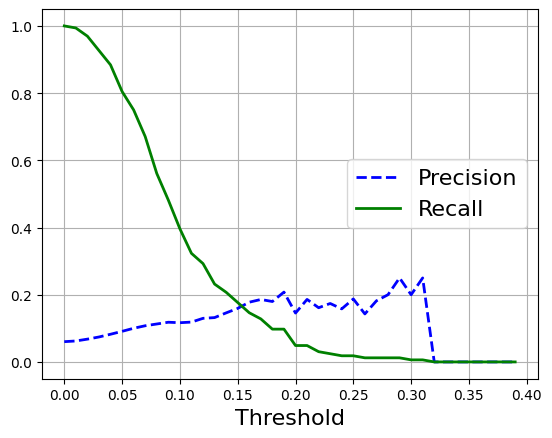

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    #plt.axis([-50000, 50000, 0, 1])             # Not shown


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

## Evaluate random forest model with altered threshold value 

With the threshold set to 0.15, the random forest will have a true positive rate of about 22%. 22% of the members that it say's will have coexistence should actually have coexistence. This is an increase in efficiency of 260% compared to the initial success rate without ML of 6%. 

In [88]:
threshold = 0.15  # Threshold determined from precision-recall figure above

forest.fit(X,train_y_coex)

# Get the probabilities for the positive class
probabilities_training = forest.predict_proba(X)[:, 1]
y_pred_training = (probabilities_training >= threshold).astype(bool)

# Get the probabilities for the positive class on the test data
probabilities_test = forest.predict_proba(X_test)[:, 1]
y_pred_test = (probabilities_test >= threshold).astype(bool)


# Evaluate the model on the training data
accuracy = accuracy_score(train_y_coex, y_pred_training)
confusion = labeled_confusion_matrix(train_y_coex, y_pred_training)
report = classification_report(train_y_coex, y_pred_training)

print("Training data")
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(report)

print("\n")
print("Test data")

# Evaluate the model on the training data
accuracy = accuracy_score(test_Y_coex, y_pred_test)
confusion = labeled_confusion_matrix(test_Y_coex, y_pred_test)
report = classification_report(test_Y_coex, y_pred_test)

print("Training data")
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(report)

joblib.dump(forest, 'saved_models/RF_coex_103023.pkl')

Training data
Accuracy: 1.0
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         2557            0
Actual 1            0          164
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2557
        True       1.00      1.00      1.00       164

    accuracy                           1.00      2721
   macro avg       1.00      1.00      1.00      2721
weighted avg       1.00      1.00      1.00      2721



Test data
Training data
Accuracy: 0.8877887788778878
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          267           18
Actual 1           16            2
Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.94      0.94       285
        True       0.10      0.11      0.11        18

    accuracy                           0.89       303
   macro avg       0.52      0.52      0.52       303
weighted avg       0.89   

['saved_models/RF_coex_103023.pkl']

## Build a RF regressor model to predict shannon's equitability index

ShannonE scores above 0.7 generally exclude the poorest performing param sets

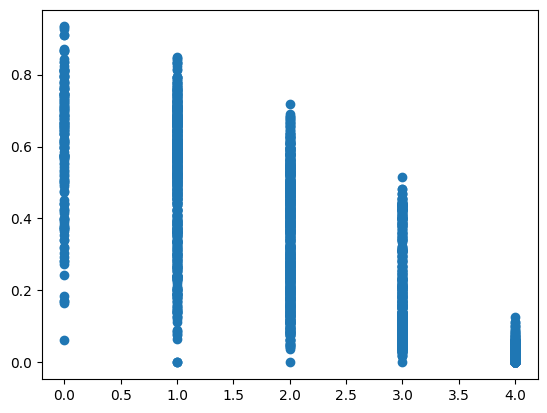

In [41]:
plt.scatter(train_set['FailedPFTs'],train_set['ShannonE'])
plt.show()
plt.xlabel("Number of failed pfts")
plt.ylabel("")

We have to bin the data to get some high shannon scores in the test data

In [55]:
df["ShannonE_cat"] = pd.cut(df["ShannonE"],
                           bins = [-0.01,0.25,0.50,0.75,np.inf],
                           labels = [1,2,3,4])

<Axes: >

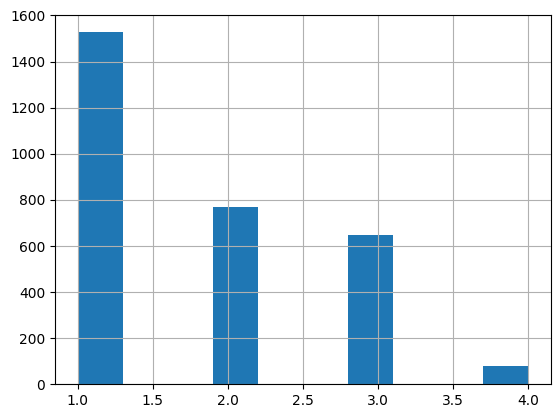

In [56]:
df["ShannonE_cat"].hist()

## Split the data while stratifying across the different ShannonE groups

In [61]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.1, random_state = 42)

# Split the data into training and test sets, maintaining an equal proportion of veg and non-veg labels in each.
for train_index, test_index in split.split(df, df['ShannonE_cat']):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]
    
X_cols = train_set.columns[train_set.columns.str.contains('fates')]
train_X = train_set[X_cols]
test_X = test_set[X_cols]

#Create vars to be predicted
train_y_coex = train_set["coexistence"].copy()
train_y_shannonE = train_set["ShannonE"].copy()
train_y_failedPFTs = train_set["FailedPFTs"].copy()

test_Y_coex = test_set["coexistence"].copy()
test_y_shannonE = test_set["ShannonE"].copy()
test_y_failedPFTs = test_set["FailedPFTs"].copy()

# Apply transformation pipeline to training data
X = transformation_pipeline.fit_transform(train_X)
# Apply to test data

X_test = transformation_pipeline.fit_transform(test_X)

## Train and evaluate a non-optimized random forest regressor

There is very little predictive power here.

Scores: [0.19987329 0.18817756 0.20445951 0.20049864 0.21232255 0.20080414
 0.20564374 0.19532841 0.20242907 0.18832077]
Mean: 0.19978576701638037
Standard deviation: 0.007126956362220488


Text(0, 0.5, 'Prediction')

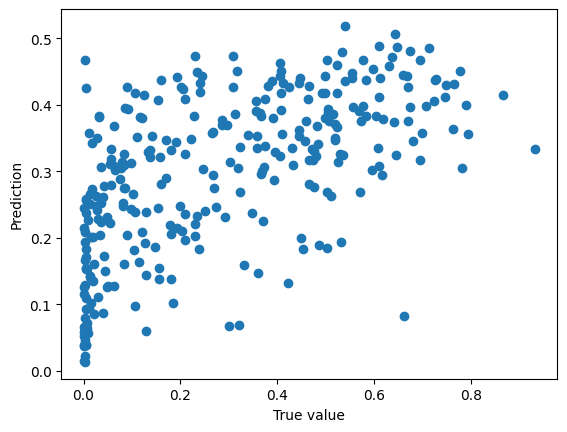

In [63]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)

forest_reg_scores = cross_val_score(forest_reg,X,train_y_shannonE,cv=10,scoring="neg_mean_squared_error")
tree_reg_rmse_scores = np.sqrt(-forest_reg_scores)
display_scores(tree_reg_rmse_scores)

forest_reg.fit(X,train_y_shannonE)
forest_reg_train_preds = forest_reg.predict(X)
forest_reg_test_preds = forest_reg.predict(X_test)

plt.scatter(test_y_shannonE,forest_reg_test_preds)
plt.xlabel("True value")
plt.ylabel("Prediction")

## RF model to predict the number of failed pfts

It should be better at doing this because it will have more data. It might still confuse cases where 1 or 0 pfts fail, but it would still be useful to rule out cases where >1 pfts fail and it might be able to do a good job of this.

## Stratify data by number of failed pfts

<Axes: >

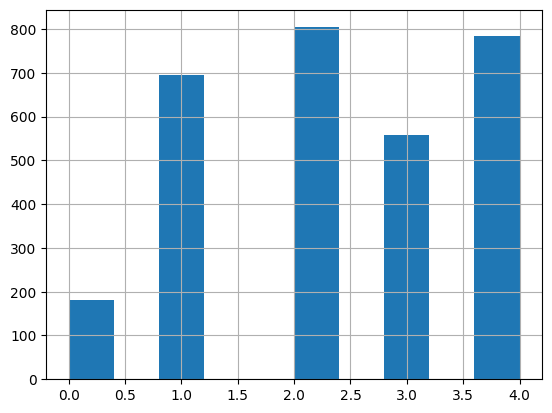

In [64]:
df["FailedPFTs"].hist()

In [65]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.1, random_state = 42)

# Split the data into training and test sets, maintaining an equal proportion of veg and non-veg labels in each.
for train_index, test_index in split.split(df, df['FailedPFTs']):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]
    
X_cols = train_set.columns[train_set.columns.str.contains('fates')]
train_X = train_set[X_cols]
test_X = test_set[X_cols]

#Create vars to be predicted
train_y_coex = train_set["coexistence"].copy()
train_y_shannonE = train_set["ShannonE"].copy()
train_y_failedPFTs = train_set["FailedPFTs"].copy()

test_Y_coex = test_set["coexistence"].copy()
test_y_shannonE = test_set["ShannonE"].copy()
test_y_failedPFTs = test_set["FailedPFTs"].copy()


# Apply transformation pipeline to training data
X = transformation_pipeline.fit_transform(train_X)
# Apply to test data

X_test = transformation_pipeline.fit_transform(test_X)

## Evaluate accuracy of multi-class classifier

In [66]:
forest_failedPFTs = RandomForestClassifier(random_state=42)
forest_failedPFTs_scores = cross_val_score(forest_failedPFTs,X,train_y_failedPFTs,cv=10,scoring="accuracy")
display_scores(forest_failedPFTs_scores)

Scores: [0.47985348 0.49632353 0.46323529 0.48161765 0.46323529 0.46691176
 0.49632353 0.45220588 0.46691176 0.44485294]
Mean: 0.47114711269123044
Standard deviation: 0.016322869204435722


## Confusion matrix on validation data

In [75]:
train_y_failedPFTs.value_counts()

FailedPFTs
2    723
4    706
1    626
3    502
0    164
Name: count, dtype: int64

<Axes: >

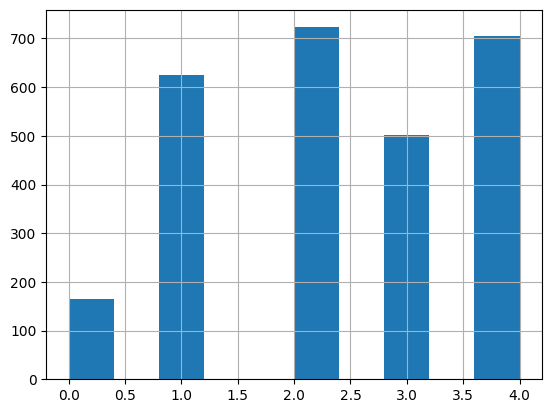

In [70]:
train_y_failedPFTs.hist()

In [86]:
y_pred_failedPFTs = cross_val_predict(forest_failedPFTs,X,train_y_failedPFTs,cv=3)
labeled_confusion_matrix(train_y_failedPFTs,y_pred_failedPFTs,labels=[0,1,2,3,4])

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 0,0,78,64,5,17
Actual 1,0,232,284,15,95
Actual 2,0,172,412,25,114
Actual 3,0,68,178,21,235
Actual 4,0,56,55,26,569


## Confusion matrix on test data

Here we see that it never predict total coexistence among the 5 pfts, but when it predicts that 1 pft will fail we rarely get a scenario where 3 or 4 pfts failed, so we can use this to weed out the worst cases.

In [85]:
forest_failedPFTs.fit(X,train_y_failedPFTs)
y_pred_failedPFTs_test = forest_failedPFTs.predict(X_test)
labeled_confusion_matrix(test_y_failedPFTs,y_pred_failedPFTs_test,labels = [0,1,2,3,4])



,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 0,0,6,9,0,3
Actual 1,0,27,35,2,6
Actual 2,0,20,40,4,17
Actual 3,0,7,17,3,29
Actual 4,0,4,10,2,62


## Save the multi-class model

In [87]:
joblib.dump(forest_failedPFTs, 'saved_models/RF_NFailedPFTs_103023.pkl')

['RF_NFailedPFTs_103023.pkl']

## Hyperparameter optimization for multi-class classification

I'm going to save doing this until I have more training data

In [ ]:
#Here we use the GridSearchCV function to find optimal hyperparameters

#However, we can also use RandomizedSearchCV where you can specify the
#Number of iterations directly and pull from (I guess) a distribution of hyperparameters

# from sklearn.model_selection import GridSearchCV

# param_grid = [
#     {'n_estimators': [35, 100, 500], 'max_features': [0.25, 0.5, 0.8]},
#     {'bootstrap': [False], 'n_estimators': [35, 100, 500], 'max_features': [0.25, 0.5, 0.8]},
#   ]

# forest_grid = RandomForestClassifier()

# # train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
# grid_search = GridSearchCV(forest_grid, param_grid, cv=5,
#                            scoring='accuracy',
#                            return_train_score=True)
# grid_search.fit(X, train_y_coex)
# grid_search.best_params_

## Hyperparameter optimization for binary classification random forest model

In [ ]:
#Here we use the GridSearchCV function to find optimal hyperparameters

#However, we can also use RandomizedSearchCV where you can specify the
#Number of iterations directly and pull from (I guess) a distribution of hyperparameters

# from sklearn.model_selection import GridSearchCV

# param_grid = [
#     {'n_estimators': [35, 100, 500], 'max_features': [0.25, 0.5, 0.8]},
#     {'bootstrap': [False], 'n_estimators': [35, 100, 500], 'max_features': [0.25, 0.5, 0.8]},
#   ]

# forest_grid = RandomForestClassifier()

# # train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
# grid_search = GridSearchCV(forest_grid, param_grid, cv=5,
#                            scoring='accuracy',
#                            return_train_score=True)
# grid_search.fit(X, train_y_coex)
# grid_search.best_params_

### See results of the hyperparameter optimization

Scores are not very sensitive to these hyperparameters, but best had these params:{'max_features': 0.25, 'n_estimators': 100}

In [ ]:
# cvres = grid_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
#     print(mean_score,params)

## Support Vector Machine

In [ ]:
# from sklearn.svm import SVC

# svm_clf = SVC(gamma="auto", random_state=42)
# svm_scores = cross_val_score(svm_clf,X,train_y_coex,cv=10,scoring="accuracy")
# print("Naive:",naive_scores)
# print("\n")
# print("SVM:",svm_scores)

## Stochastic Gradient Descent Classifier

This is crashing the kernel

In [ ]:
# from sklearn.linear_model import SGDClassifier

# sgd_clf = SGDClassifier(random_state=42)

# sgd_scores = cross_val_score(sgd_clf,X,train_y_coex,cv=10,scoring="accuracy")

# print("Naive:",naive_scores)
# print("\n")
# print("SGD:",sgd_scores_scores)